In [1]:
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader

# Step 1: Load dataset from Excel

In [2]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Define file path (Update the filename to match your uploaded Excel file)
file_path = "/content/gdrive/My Drive/Colab Notebooks/edu.xlsx"

# Load dataset
df = pd.read_excel(file_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Ensure necessary columns exist

In [3]:
assert {'Dholuo Phrase', 'Swahili Phrase', 'Thematic Area'}.issubset(df.columns), "Missing required columns!"

Step 2: Data Preprocessing
# Combine Dholuo and Swahili phrases into a single text input

In [4]:
# Restructure dataset: Separate Dholuo and Swahili into individual rows
df_dholuo = df[['Dholuo Phrase', 'Thematic Area']].rename(columns={'Dholuo Phrase': 'Phrase'})
df_swahili = df[['Swahili Phrase', 'Thematic Area']].rename(columns={'Swahili Phrase': 'Phrase'})

# Combine both into a single dataset
df_final = pd.concat([df_dholuo, df_swahili], ignore_index=True)

# Shuffle the dataset
df_final = df_final.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the first few rows
print(df_final.head())


                                              Phrase         Thematic Area
0             ulikuwa mrefu na wenye mivutano mingi.        Social setting
1  wanyama hao ni kama vile nyoka na wadudu wengi...        Social setting
2                          naenda hospitali karibuni            Healthcare
3                  wuod rose okumu ne othoo go kinyi        News and media
4         wengine wakajituma kama si kutumwa sokoni.  Business and finance


In [5]:
# Encode labels into numerical values
thematic_labels = {label: i for i, label in enumerate(df["Thematic Area"].unique())}

# Apply encoding to the column
df["Thematic Area"] = df["Thematic Area"].map(thematic_labels)

In [6]:
from sklearn.model_selection import train_test_split

# Extract features (both Swahili and Dholuo phrases) and labels
swahili_texts = df["Swahili Phrase"]
dholuo_texts = df["Dholuo Phrase"]
labels = df["Thematic Area"]  # Encoded labels

# First split: Train (70%) and Temp (30%)
train_swahili, temp_swahili, train_dholuo, temp_dholuo, train_labels, temp_labels = train_test_split(
    swahili_texts, dholuo_texts, labels, test_size=0.3, stratify=labels, random_state=42)

# Second split: Validation (10%) and Test (20%) from Temp (30%)
val_swahili, test_swahili, val_dholuo, test_dholuo, val_labels, test_labels = train_test_split(
    temp_swahili, temp_dholuo, temp_labels, test_size=2/3, stratify=temp_labels, random_state=42)


In [7]:
pip install transformers

In [8]:
from transformers import XLMRobertaTokenizer

# Load the pre-trained XLM-R tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [9]:
def tokenize_texts(swahili_texts, dholuo_texts):
    # Convert NaN values to empty strings and ensure all elements are strings
    combined_texts = [str(s if isinstance(s, str) else "") + " [SEP] " + str(d if isinstance(d, str) else "")
                      for s, d in zip(swahili_texts, dholuo_texts)]

    return tokenizer(
        combined_texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# Tokenize train, validation, and test sets
train_encodings = tokenize_texts(train_swahili, train_dholuo)
val_encodings = tokenize_texts(val_swahili, val_dholuo)
test_encodings = tokenize_texts(test_swahili, test_dholuo)


In [10]:
import torch
from torch.utils.data import Dataset

# Assuming you have already tokenized `train_encodings`, `val_encodings`, and `test_encodings`

class ThematicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        # Ensure labels are in tensor form
        self.labels = torch.tensor(labels.values if isinstance(labels, pd.Series) else labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get the item for tokenized features and labels
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create datasets for training, validation, and testing
train_dataset = ThematicDataset(train_encodings, train_labels)
val_dataset = ThematicDataset(val_encodings, val_labels)
test_dataset = ThematicDataset(test_encodings, test_labels)


In [11]:
from transformers import XLMRobertaForSequenceClassification
import torch

# Assuming thematic_labels is defined and contains your unique label mapping
thematic_labels = {label: i for i, label in enumerate(labels.unique())}

# Load XLM-RoBERTa model with classification head
model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=len(thematic_labels))

# Move model to the correct device (if using GPU)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=

In [12]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=8,  # Increased epochs
    per_device_train_batch_size=16,  # Increased batch size
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=3e-5,  # Lower learning rate for better fine-tuning
    weight_decay=0.01,
    warmup_ratio=0.1,  # Adjusted warmup dynamically
    lr_scheduler_type="linear",  # Smooth learning rate decay
    gradient_accumulation_steps=2,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,  # Prevents excessive storage usage
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [13]:
!pip install --upgrade transformers

In [14]:
from transformers import DataCollatorWithPadding

# Use a simple data collator that handles padding dynamically
data_collator = DataCollatorWithPadding(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-14-6696a30f5db6>:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [17]:
# Initialize Trainer with the modified settings
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics  # Include this function
)

<ipython-input-17-64044d142fb6>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.295500,1.272046,0.599608,0.597188,0.599608,0.580675
2,1.252200,1.162543,0.609406,0.561939,0.609406,0.576369
3,1.059200,1.124233,0.615284,0.609710,0.615284,0.600404
4,0.833800,1.126200,0.625735,0.611187,0.625735,0.613687
5,0.870400,1.156963,0.625408,0.615249,0.625408,0.611453
6,0.780800,1.234362,0.615937,0.611250,0.615937,0.610030
7,0.620400,1.268633,0.619530,0.613816,0.619530,0.615281
8,0.557500,1.296379,0.620509,0.614554,0.620509,0.615471


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=5360, training_loss=0.8923137559819577, metrics={'train_runtime': 2210.3004, 'train_samples_per_second': 77.579, 'train_steps_per_second': 2.425, 'total_flos': 2.68782618236832e+16, 'train_loss': 0.8923137559819577, 'epoch': 8.0})

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Get predictions
predictions = trainer.predict(test_dataset).predictions.argmax(-1)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predictions, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6239
Precision: 0.6150
Recall: 0.6239
F1 Score: 0.6141


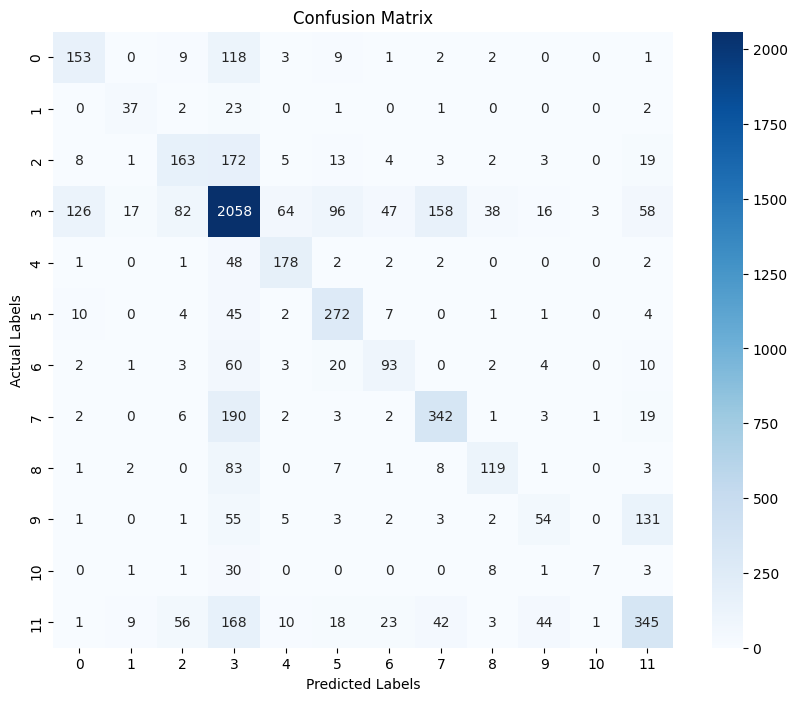

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(thematic_labels.keys()),  # Convert dict_keys to list
    yticklabels=list(thematic_labels.keys())
)

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [25]:
# Save model and tokenizer
model.save_pretrained("./trained1_model")
tokenizer.save_pretrained("./trained1_model")

print("Model and tokenizer saved successfully!")

Model and tokenizer saved successfully!


In [26]:
import shutil

# Zip the trained model directory
shutil.make_archive("trained1_model", 'zip', "./trained1_model")

print("Model zipped successfully!")

Model zipped successfully!
